# Introduction

In this notebook, we will explore the popular MNIST dataset which contains a large set of images of handwritten digits. Our objective is to train a classifier that can accurately recognize the digits in these images. To achieve this, we will:
* Perform various data preprocessing steps such as data augmentation, scaling, and principal component analysis (PCA) to improve model performance.
* Evaluate several machine learning models, with focusing on the support vector classifier (SVC).
* Use techniques such as fine-tuning and grid search to optimize their performance.

Overall, this notebook serves as an introduction to image classification with machine learning and provides insights into the techniques and tools used for this task.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import imgaug.augmenters as iaa
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from scipy.stats import randint
from scipy.ndimage.interpolation import shift
from IPython.display import Markdown, display
from matplotlib.colors import ListedColormap

# to make this notebook's output stable across runs
np.random.seed(42)

## Data Collection

In [2]:
dataset = pd.read_csv('../input/digit-recognizer/train.csv')
dataset_test = pd.read_csv('../input/digit-recognizer/test.csv')
# digits_submit = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

## Data Analysis

Explore the MNIST dataset by analyzing its distribution, visualizing some of its samples.

In [3]:
print(f'Train dataset shape:\t {dataset.shape}',
    f'\nTest dataset shape:\t {dataset_test.shape}')

Train dataset shape:	 (42000, 785) 
Test dataset shape:	 (28000, 784)


In [4]:
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dataset_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check for null and missing values

In [6]:
print('Train dataset, missing values:', dataset.isna().sum().sum())

Train dataset, missing values: 0


In [7]:
print('Test dataset, missing values:', dataset_test.isna().sum().sum())

Test dataset, missing values: 0


There are no missing values in the train and test datasets. So there are no corrupted images

### Data visualization

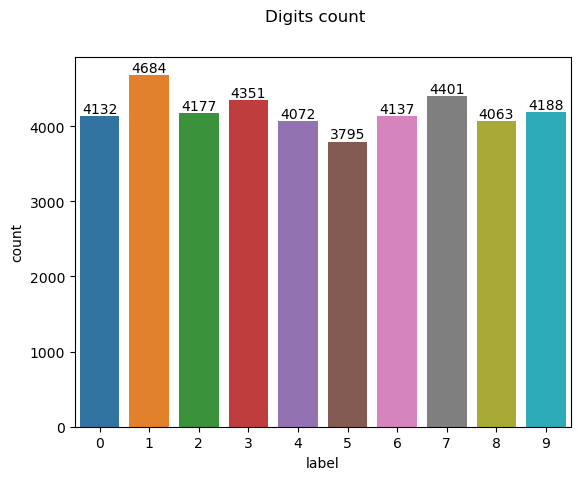

In [8]:
ax = sns.countplot(x='label', data=dataset)
ax.figure.suptitle('Digits count')
for container in ax.containers:
    ax.bar_label(container)

It looks nearly balanced.

Create function to plot digits

In [9]:
def plot_digits(instances, actual_labels, predicted_labels, images_per_row=10, figsize=(8,8), **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    fig = plt.figure(figsize=figsize)
    for i in range(len(padded_instances)):
        ax = fig.add_subplot(n_rows, images_per_row, i + 1)
        grid_data = padded_instances[i].reshape(28,28)
        plt.imshow(grid_data, cmap = mpl.cm.binary, interpolation="nearest")
        actual_title = f'Actual: {actual_labels[i]}' if len(actual_labels) else ''
        predicted_title = f'\nPredicted: {predicted_labels[i]}' if len(predicted_labels) else ''
        ax.set_title(f'{actual_title}{predicted_title}')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.patch.set_linewidth('1')
        ax.spines['bottom'].set_color('lightgray')
        ax.spines['top'].set_color('lightgray') 
        ax.spines['right'].set_color('lightgray')
        ax.spines['left'].set_color('lightgray')
    fig.tight_layout()

Plot one random digit

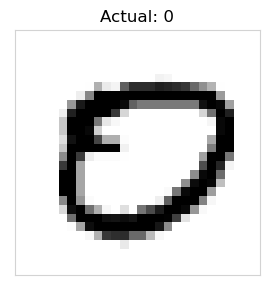

In [10]:
example_index = randint.rvs(0, len(dataset)-1, size=1)[0]
example_image = dataset.iloc[example_index, 1:785]
example_label = dataset.iloc[example_index, 0]
plot_digits([example_image], [example_label], [], images_per_row=1, figsize=(3,3))

Plot multiple random digits

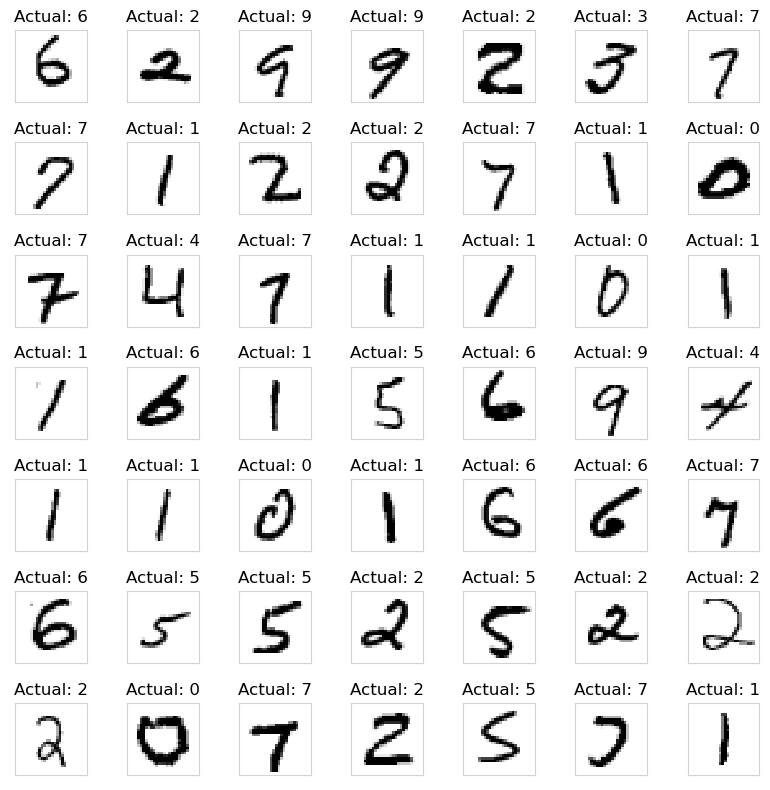

In [11]:
exmaple_indexes = randint.rvs(0, len(dataset)-1, size=49)
example_images = dataset.iloc[exmaple_indexes, 1:785].to_numpy()
example_labels = dataset.iloc[exmaple_indexes, 0].to_numpy()
plot_digits(example_images, example_labels, [], images_per_row=7)

## Data Preprocessing

In [12]:
X_train, X_val, y_train, y_val = train_test_split(dataset, 
                                                    dataset['label'], 
                                                    test_size=0.25, 
                                                    stratify = dataset['label'])
X_train = X_train.drop("label", axis=1)
y_train = y_train.to_numpy()
X_val = X_val.drop("label", axis=1)
y_val = y_val.to_numpy()
print(f'Train shape. \t\tX: {X_train.shape}, y: {y_train.shape}',
    f'\nValidation shape. \tX: {X_val.shape}, y: {y_val.shape}')

Train shape. 		X: (31500, 784), y: (31500,) 
Validation shape. 	X: (10500, 784), y: (10500,)


### Data augmentation

Create functions for data augmentation

In [13]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [14]:
def rotate_image(image, angle):
    rotate_augmenter = iaa.Rotate(angle)
    return rotate_augmenter.augment_image(image.reshape(28, 28)).reshape(784)

Visualize random augmentated digit

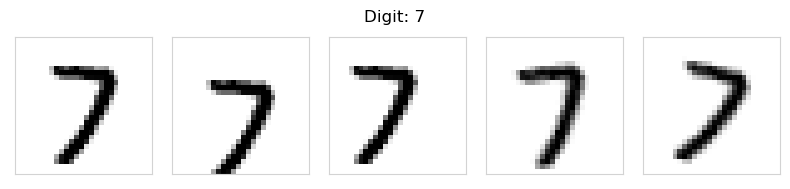

In [15]:
exmaple_index = randint.rvs(0, len(X_train)-1, size=1)[0]
original_image = X_train.iloc[exmaple_index].to_numpy()
shifted_image_down = shift_image(original_image, 0, 3)
shifted_image_left = shift_image(original_image, -3, 0)
rotated_image_left = rotate_image(original_image.astype(np.uint8), -10)
rotated_image_right = rotate_image(original_image.astype(np.uint8), 10)
all_images = [original_image, 
              shifted_image_down, shifted_image_left, 
              rotated_image_left, rotated_image_right]
plot_digits(all_images, [], [], images_per_row=5, figsize=(8,2))
plt.suptitle(f'Digit: {y_train[exmaple_index]}')
plt.show()

After some experimenting with models' performance, I decided to use 1-pixel shifting and 10-degrees rotation.

In [16]:
X_train_augmented = [X_train]
y_train_augmented = [y_train]
for dx, dy in ((0, 1), (1, 0), (-1, 0), (0, -1)):
    shifted_images = np.apply_along_axis(shift_image, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_augmented.append(shifted_images)
    y_train_augmented.append(y_train)
for angle in [10, -10]:
    rotated_images = np.apply_along_axis(rotate_image, axis=1, arr=X_train.astype(np.uint8), angle=angle)
    X_train_augmented.append(rotated_images)
    y_train_augmented.append(y_train)
X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)
print(f'Train (augmented) shape. \tX: {X_train_augmented.shape}, y: {y_train_augmented.shape}')

Train (augmented) shape. 	X: (220500, 784), y: (220500,)


Shuffle augmented training data

In [17]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Visualize some digits to make sure everything is correct after augmentation and shuffling.

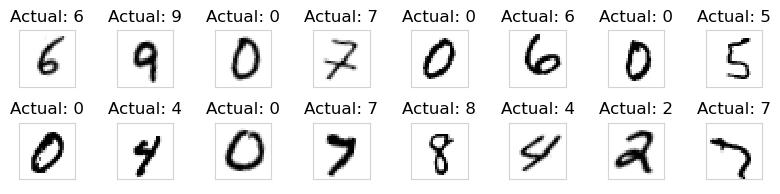

In [18]:
exmaple_indexes = randint.rvs(0, len(X_train_augmented)-1, size=16)
example_images = X_train_augmented[exmaple_indexes]
example_labels = y_train_augmented[exmaple_indexes]
plot_digits(example_images, example_labels, [], images_per_row=8, figsize=(8,2))

## Model Training and Evaluation

Create functions for reporting

In [19]:
def plot_confusion_matrix(conf_mx, ax):
    norm_conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1, keepdims=True)
    np.fill_diagonal(norm_conf_mx, 0)
    sns.heatmap(norm_conf_mx, ax=ax, annot=False, cmap=plt.cm.gray, cbar=False)
    plt.title('Confusion matrix')
    thresh = norm_conf_mx.max() / 2
    for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
        plt.text(j+0.5, i+0.6, conf_mx[i, j],
            ha="center",
            va='baseline',
            color="white" if norm_conf_mx[i, j] < thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def plot_classification_report(clf_report, ax, vmin=0.93, vmax=1):
    mask1 = np.zeros_like(clf_report, dtype=bool)
    mask1[10:, :] = True
    mask2 = np.zeros_like(clf_report, dtype=bool)
    mask2[:10, :] = True
    cmap_white = ListedColormap(['white'])
    sns.heatmap(clf_report, ax=ax, mask=mask1, annot=True, 
                cmap='viridis', fmt='.6f', vmin=vmin, vmax=vmax, cbar=False)
    sns.heatmap(clf_report, ax=ax, mask=mask2, annot=True, 
                cmap=cmap_white, fmt='.6f', cbar=False)
    ax.set_title("Classification report", fontsize=10, pad=10)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

In [21]:
def display_evalreport(y_actual, y_predicted, set_name):
    display(Markdown(f'## <span style="color: black;">Evaluation on the {set_name}</span>'))
    accuracy = accuracy_score(y_actual, y_predicted)
    display(Markdown('Accuracy: {:.4f}%'.format(accuracy*100)))
    conf_mx = confusion_matrix(y_actual, y_predicted)
    classif_report_df = pd.DataFrame(classification_report(y_actual, y_predicted, output_dict=True)).iloc[:-1, :].T
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, 
                               gridspec_kw={'width_ratios': [1, 2.2]}, dpi=100)
    plot_classification_report(classif_report_df, ax0)
    plot_confusion_matrix(conf_mx, ax1)
    fig.tight_layout()
    plt.show()

Create a pipeline for further training usage

In [22]:
pipeline = Pipeline([
    ('scaler', None),
    ('pca', None),
    ('model', None)
])

### Determine estimator

Determine which model to fine-tune and which scaler to use.

In [23]:
params = [
    {'model': [
        SVC(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        GaussianNB()
    ],
     'scaler': [MinMaxScaler(), StandardScaler(), Binarizer(threshold=50)]
    }]
grid_search = GridSearchCV(pipeline, params, cv=3, 
                           scoring='f1_macro', n_jobs=-1, 
                           verbose=1)
grid_search.fit(X_train[:20000], y_train[:20000])
(pd.DataFrame(grid_search.cv_results_)
    .sort_values(by=['rank_test_score'], ascending=True))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,51.862467,0.529412,47.597923,1.657963,SVC(),MinMaxScaler(),"{'model': SVC(), 'scaler': MinMaxScaler()}",0.960000,0.967561,0.962945,0.963502,0.003112,1
2,46.246396,4.482690,51.326644,0.605211,SVC(),Binarizer(threshold=50),"{'model': SVC(), 'scaler': Binarizer(threshold...",0.956773,0.966565,0.961195,0.961511,0.004004,2
6,0.290801,0.007706,10.930395,0.148690,KNeighborsClassifier(),MinMaxScaler(),"{'model': KNeighborsClassifier(), 'scaler': Mi...",0.953433,0.956516,0.953507,0.954485,0.001436,3
5,7.492724,0.166352,0.579156,0.014022,RandomForestClassifier(),Binarizer(threshold=50),"{'model': RandomForestClassifier(), 'scaler': ...",0.949012,0.956449,0.954913,0.953458,0.003206,4
3,13.878844,0.211813,0.463196,0.006478,RandomForestClassifier(),MinMaxScaler(),"{'model': RandomForestClassifier(), 'scaler': ...",0.950564,0.957059,0.952468,0.953364,0.002726,5
4,12.928480,0.556392,0.461433,0.012709,RandomForestClassifier(),StandardScaler(),"{'model': RandomForestClassifier(), 'scaler': ...",0.949169,0.957362,0.949113,0.951881,0.003876,6
8,0.309545,0.014859,10.787749,0.320455,KNeighborsClassifier(),Binarizer(threshold=50),"{'model': KNeighborsClassifier(), 'scaler': Bi...",0.950102,0.956559,0.948884,0.951848,0.003368,7
1,69.869894,1.666615,55.272636,0.675900,SVC(),StandardScaler(),"{'model': SVC(), 'scaler': StandardScaler()}",0.940448,0.947375,0.940427,0.942750,0.003270,8
7,0.350849,0.007202,10.643184,0.565795,KNeighborsClassifier(),StandardScaler(),"{'model': KNeighborsClassifier(), 'scaler': St...",0.918311,0.922387,0.919577,0.920092,0.001703,9
9,0.570842,0.059489,0.687037,0.082456,GaussianNB(),MinMaxScaler(),"{'model': GaussianNB(), 'scaler': MinMaxScaler()}",0.528298,0.533998,0.509315,0.523870,0.010552,10


In [24]:
grid_search.best_params_

{'model': SVC(), 'scaler': MinMaxScaler()}

We see that the SVC classifier and MinMaxScaler are the best ones. Binarizer is a little bit faster, however, MinMaxScaler gives better score.

In [25]:
base_estimator = grid_search.best_estimator_
y_val_predicted = base_estimator.predict(X_val)

## <span style="color: black;">Evaluation on the Validation Set (base estimator)</span>

Accuracy: 96.7714%

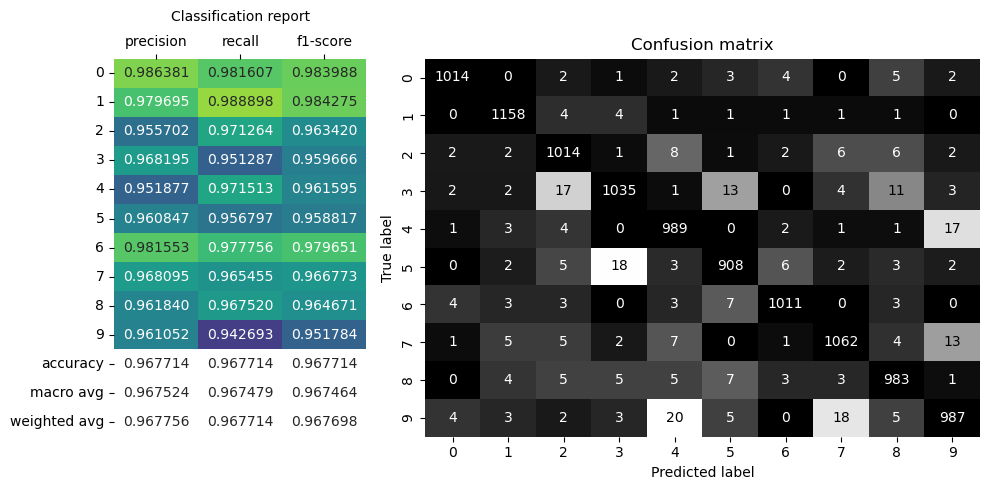

In [26]:
display_evalreport(y_val, y_val_predicted, "Validation Set (base estimator)")

As we see, some digits such as "0", "1", "6" are recognized relatively good. Others have a lot of misclassifications. For example, the digit "4" has many confusions with "9", and the digit "5" is often missclassified as "3", and so on.

### Analyze performance with PCA

Build a plot of the cumulative explained variance.

In [27]:
mmscaler = MinMaxScaler()
X_train_scaled = mmscaler.fit_transform(X_train)
pca = PCA(n_components=784)
pca.fit(X_train_scaled)

PCA(n_components=784)

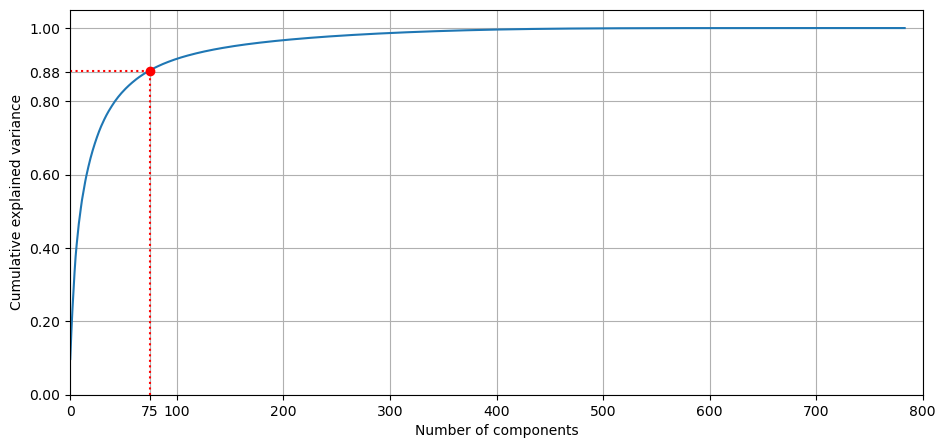

In [28]:
f, ax = plt.subplots(1, figsize=(11,5))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
n_comp_example = 75
cev_example = np.cumsum(pca.explained_variance_ratio_[:n_comp_example])[-1]
ax.plot([n_comp_example, n_comp_example], [0., cev_example], "r:")
ax.plot([0.0, n_comp_example], [cev_example, cev_example], "r:")
ax.plot([n_comp_example], [cev_example], "ro")
ax.set_xticks(list(ax.get_xticks()) + [n_comp_example])
ax.set_yticks(list(ax.get_yticks()) + [round(cev_example, 2)])
ax.set_xlim(0, 800)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance')
ax.grid()
plt.show()

We see that 100 components describes about 90% of the variance. Let's evaluate different numbers of components on the training set. Looking ahead, I chose a number of 75, which corresponds to about 88% of the variance. Accordingly, I plotted this point on the graph.

In [29]:
params = [{
    'model': [SVC()],
    'scaler': [MinMaxScaler()],
    'pca': [PCA()],
    'pca__n_components': [2, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 784]
    }]
grid_search_pca = HalvingGridSearchCV(pipeline, params, cv=3, 
                           scoring='f1_macro', n_jobs=-1, 
                           verbose=1)
grid_search_pca.fit(X_train, y_train)
(pd.DataFrame(grid_search_pca.cv_results_)
    .sort_values(by=['rank_test_score'], ascending=True))

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 3500
max_resources_: 31500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13
n_resources: 3500
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 1
n_candidates: 5
n_resources: 10500
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 31500
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_pca,param_pca__n_components,param_scaler,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,2,31500,16.899240,4.405765,10.166053,2.474917,SVC(),PCA(n_components=75),75,MinMaxScaler(),...,0.976090,0.975363,0.976836,0.001597,1,0.990925,0.991758,0.991973,0.991552,0.000452
18,2,31500,22.664035,1.464937,16.308341,0.098975,SVC(),PCA(n_components=75),100,MinMaxScaler(),...,0.975530,0.974768,0.976165,0.001470,2,0.991306,0.992342,0.992635,0.992094,0.000570
16,1,10500,4.301273,0.294954,2.324113,0.096503,SVC(),PCA(n_components=75),75,MinMaxScaler(),...,0.960688,0.963061,0.962894,0.001737,3,0.991798,0.990874,0.992021,0.991564,0.000497
17,1,10500,3.943389,0.038636,2.440250,0.165480,SVC(),PCA(n_components=75),100,MinMaxScaler(),...,0.960450,0.963027,0.962602,0.001612,4,0.992947,0.991731,0.991870,0.992183,0.000543
15,1,10500,3.273494,0.088325,1.939165,0.182286,SVC(),PCA(n_components=75),50,MinMaxScaler(),...,0.960885,0.963637,0.962147,0.001135,5,0.989368,0.989170,0.990289,0.989609,0.000488
14,1,10500,6.072194,0.270776,5.858174,0.113860,SVC(),PCA(n_components=75),200,MinMaxScaler(),...,0.960062,0.963021,0.962009,0.001377,6,0.993386,0.992735,0.993156,0.993092,0.000269
13,1,10500,9.147464,0.236080,8.324565,0.274831,SVC(),PCA(n_components=75),300,MinMaxScaler(),...,0.959445,0.962742,0.961609,0.001531,7,0.993391,0.992884,0.993736,0.993337,0.000350
5,0,3500,1.155569,0.193029,0.442879,0.006793,SVC(),PCA(n_components=75),100,MinMaxScaler(),...,0.942777,0.949148,0.945485,0.002687,8,0.986018,0.992316,0.990900,0.989745,0.002698
4,0,3500,1.290098,0.084905,0.447674,0.067289,SVC(),PCA(n_components=75),75,MinMaxScaler(),...,0.945367,0.947422,0.945472,0.001550,9,0.984298,0.991841,0.989209,0.988449,0.003126
3,0,3500,0.807884,0.017509,0.318647,0.004383,SVC(),PCA(n_components=75),50,MinMaxScaler(),...,0.943398,0.947501,0.944789,0.001918,10,0.982944,0.985736,0.988317,0.985666,0.002194


In [30]:
grid_search_pca.best_params_

{'model': SVC(),
 'pca': PCA(n_components=75),
 'pca__n_components': 75,
 'scaler': MinMaxScaler()}

In [31]:
pca_estimator = grid_search_pca.best_estimator_
y_val_predicted_pca = pca_estimator.predict(X_val)

## <span style="color: black;">Evaluation on the Validation Set (base estimator + pca)</span>

Accuracy: 97.8095%

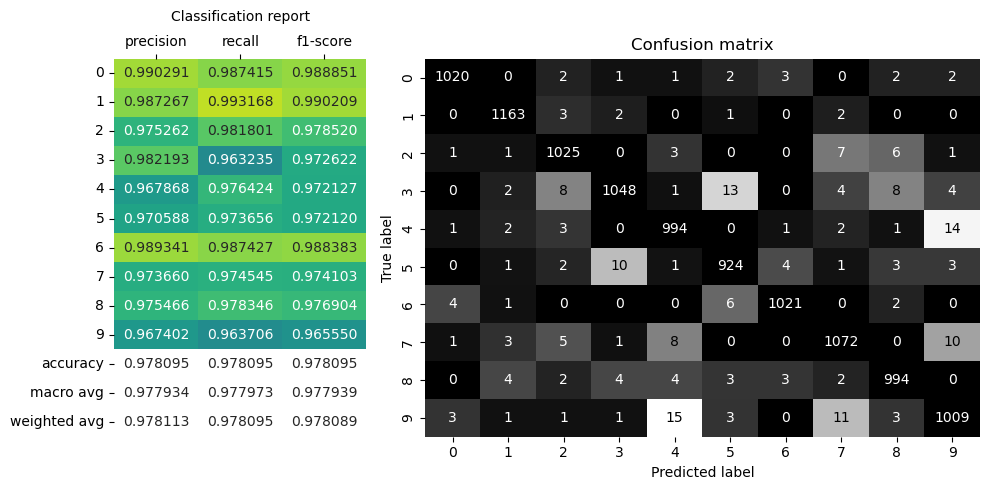

In [32]:
display_evalreport(y_val, y_val_predicted_pca, "Validation Set (base estimator + pca)")

The accuracy increased by about 1% after applying PCA. So, we see that not all digit features are important for accurate classifications.

Let's see how the digits look after reconstruction from 75 components.

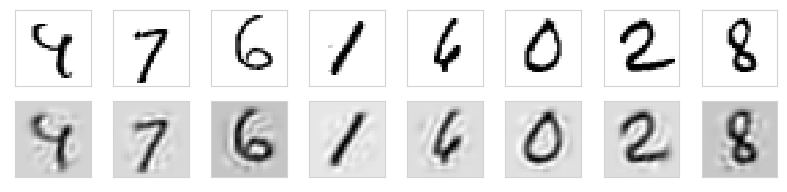

In [33]:
mmscaler = MinMaxScaler()
X_train_scaled = mmscaler.fit_transform(X_train)
pca = PCA(n_components=75)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_train_inv_pca = pca.inverse_transform(X_train_scaled_pca)
X_train_inv_sc = mmscaler.inverse_transform(X_train_inv_pca)
exmaple_indexes = randint.rvs(0, len(X_train)-1, size=8)
examples_original = X_train.iloc[exmaple_indexes]
examples_inverted = X_train_inv_sc[exmaple_indexes]
plot_digits(np.concatenate([examples_original, examples_inverted]), 
            [], [], images_per_row=8, figsize=(8,2))

The quality of the reconstructed images decreased, but the numbers are still recognizable. Of course, it will depend on the number of components.

### Fine-Tuning

Let's try to fine-tune the SVC classifier. I use here HalvingGridSearchCV instead of standard GridSearchCV. GridSearchCV performs very slow and needs a lot of minutes to evaluate all combinations, so I decided to try HalvingGridSearchCV which gives gain of speed with the same good results.

In [34]:
params_tune = [
    {
        'model': [SVC()],
        'model__kernel': ['linear', 'poly', 'rbf'],
        'model__C': [0.1, 1, 10, 100, 200, 300, 500],
        'model__gamma': [0.001, 0.01, 0.1, 1, 10],
        'model__degree': [2, 3],
        'scaler': [MinMaxScaler()],
        'pca': [PCA()],
        'pca__n_components': [75]
    }, 
]
grid_search_tuned = HalvingGridSearchCV(pipeline, params_tune, cv=5, 
                                        scoring='f1_macro', verbose=1, 
                                        n_jobs=-1, min_resources=360)
grid_search_tuned.fit(X_train, y_train)
(pd.DataFrame(grid_search_tuned.cv_results_)
    .sort_values(by=['rank_test_score'], ascending=True)
    .head())

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 360
max_resources_: 31500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 210
n_resources: 360
Fitting 5 folds for each of 210 candidates, totalling 1050 fits
----------
iter: 1
n_candidates: 70
n_resources: 1080
Fitting 5 folds for each of 70 candidates, totalling 350 fits
----------
iter: 2
n_candidates: 24
n_resources: 3240
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 8
n_resources: 9720
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 29160
Fitting 5 folds for each of 3 candidates, totalling 15 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
313,4,29160,21.330475,0.539392,4.036439,0.255224,"SVC(C=300, degree=2, gamma=0.01, kernel='poly')",300,2,0.01,...,0.974562,0.001927,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
312,4,29160,22.712755,0.568604,3.715508,0.074550,"SVC(C=300, degree=2, gamma=0.01, kernel='poly')",200,2,0.1,...,0.974521,0.001584,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
314,4,29160,18.415541,3.004336,3.586698,0.319639,"SVC(C=300, degree=2, gamma=0.01, kernel='poly')",200,2,0.01,...,0.974167,0.001992,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
304,3,9720,4.752419,0.064498,0.670845,0.016033,"SVC(C=300, degree=2, gamma=0.01, kernel='poly')",200,2,0.01,...,0.959947,0.003633,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
309,3,9720,4.865100,0.149262,0.693551,0.011406,"SVC(C=300, degree=2, gamma=0.01, kernel='poly')",300,2,0.01,...,0.959651,0.003816,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [35]:
grid_search_tuned.best_params_

{'model': SVC(C=300, degree=2, gamma=0.01, kernel='poly'),
 'model__C': 300,
 'model__degree': 2,
 'model__gamma': 0.01,
 'model__kernel': 'poly',
 'pca': PCA(n_components=75),
 'pca__n_components': 75,
 'scaler': MinMaxScaler()}

Let's look to the best HalvingGridSearchCV results.

In [36]:
tuned_estimator = grid_search_tuned.best_estimator_
y_val_predicted_tuned = tuned_estimator.predict(X_val)

## <span style="color: black;">Evaluation on the Validation Set (tuned estimator)</span>

Accuracy: 97.6095%

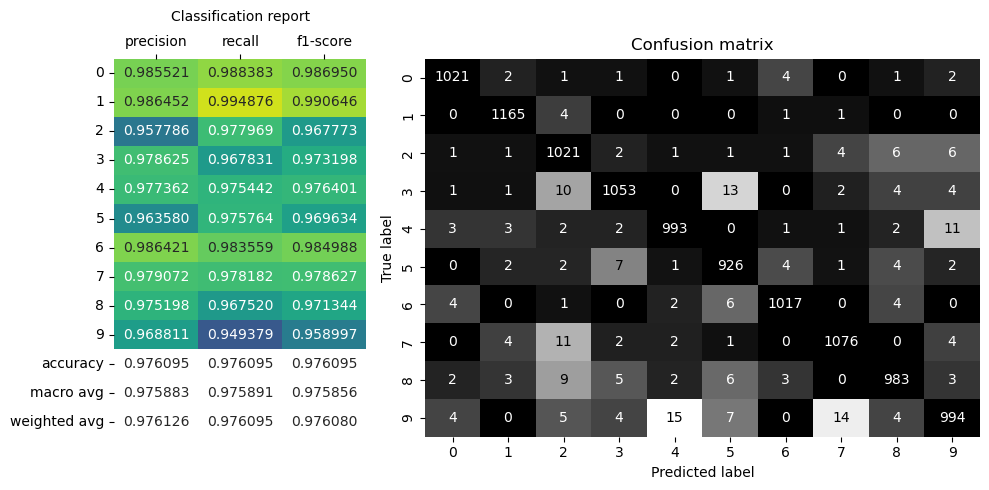

In [37]:
display_evalreport(y_val, y_val_predicted_tuned, "Validation Set (tuned estimator)")

We see that tuning also slightly increased the metrics.

Let's look at some errors after fine-tuning.

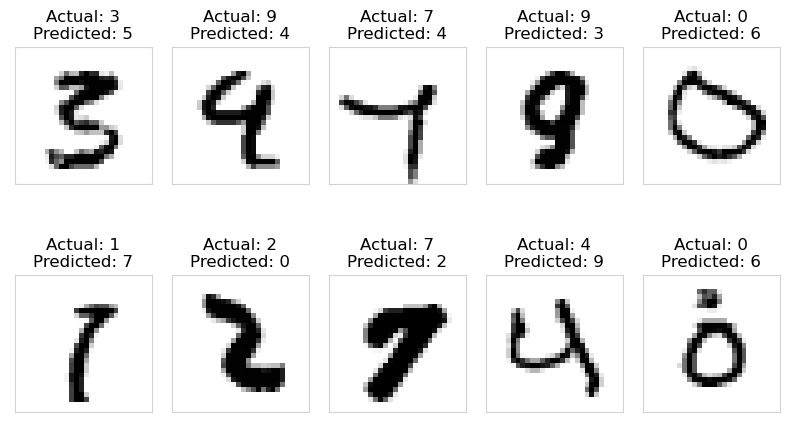

In [38]:
errors = (y_val_predicted_tuned - y_val != 0)
X_val_errors = X_val[errors]
y_val_errors = y_val[errors]
y_val_errors_predicted = y_val_predicted_tuned[errors]
exmaple_indexes = randint.rvs(0, len(X_val_errors)-1, size=10)
example_images = X_val_errors.iloc[exmaple_indexes]
example_labels = y_val_errors[exmaple_indexes]
example_labels_pred = y_val_errors_predicted[exmaple_indexes]
plot_digits(example_images, example_labels, example_labels_pred, images_per_row=5, figsize=(8,5))

### Training on augmentated data

Try to increase performance by using data augmentation.

In [39]:
proportion = X_train_augmented.shape[0]/X_train.shape[0]
print(f'Augmented set shape:\t{X_train_augmented.shape},\nBase set shape:\t\t{X_train.shape}')
print('Proportion: \t\t{:.0f}:1'.format(proportion))

Augmented set shape:	(220500, 784),
Base set shape:		(31500, 784)
Proportion: 		7:1


In [40]:
tuned_estimator.fit(X_train_augmented, y_train_augmented)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=75)),
                ('model', SVC(C=300, degree=2, gamma=0.01, kernel='poly'))])

In [41]:
y_val_predicted_aug = tuned_estimator.predict(X_val.to_numpy())

## <span style="color: black;">Evaluation on the Validation Set (augmented data)</span>

Accuracy: 98.4095%

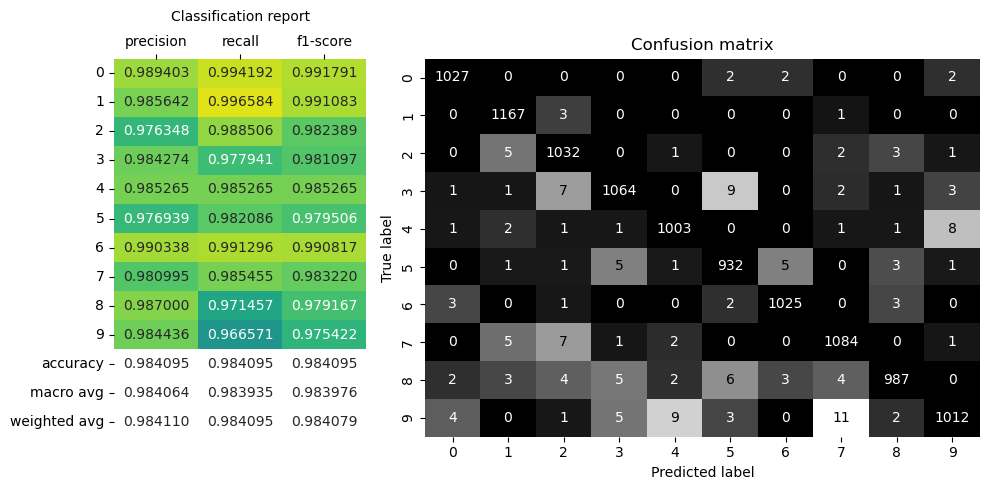

In [42]:
display_evalreport(y_val, y_val_predicted_aug, "Validation Set (augmented data)")

### Submission

Let's evaluate our results on the test set and save it in submission dataframe.

In [43]:
final_predictions = tuned_estimator.predict(dataset_test.to_numpy()) 

In [44]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(dataset_test)+1),
    "Label": final_predictions})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [45]:
# submission.to_csv('submission_mnist_svc_1.csv', index=False)

# Conclusion
SVC classifier showed it has relatively good performance. After fine-tuning and data augmentation it has reached the accuracy about 98% on the validation set.